# 🎯 Challenge 2: Medical Image Analysis - EDA & Preprocessing

## Overview
This notebook performs a comprehensive **Exploratory Data Analysis (EDA)** and **preprocessing pipeline** for medical image segmentation. The workflow includes:

- **Data Loading & Quality Control**: Loading images and masks, detecting corrupted files
- **Data Cleaning**: Removing buggy images and their associated masks
- **Mask Consistency Analysis**: Validating alignment between masks and tissue regions
- **Size & Format Analysis**: Understanding image dimensions and aspect ratios
- **Preprocessing Pipeline**: Cropping to tissue, resizing with padding, and standardization
- **Dataset Preparation**: Organizing clean data for model training

The goal is to create a clean, validated dataset with properly preprocessed images ready for deep learning classification models.

---

In [ ]:
# Install required packages for image processing
!pip install opencv-python

## 1️⃣ Setup & Data Loading

In [ ]:
#!cp /kaggle/input/kagglejson/download_and_dataframming.py .

# Import required libraries
import os
import cv2

from download_and_dataframming import load_image_dataframe, download_competition

# Load the dataset with pixel data from Kaggle competition
# This creates a DataFrame containing image paths and RGB pixel arrays
#download_competition()
df = load_image_dataframe("an2dl2526c2v2", load_pixels=True)
df.head()

>>> Scansione immagini in: an2dl2526c2v2
✓ Trovate 2116 immagini.
✓ Trovate 2116 immagini.


,path,filename,image
0,an2dl2526c2v2/test_data/img_0000.png,img_0000.png,"[[[205, 205, 203], [195, 195, 193], [197, 197,..."
1,an2dl2526c2v2/test_data/img_0001.png,img_0001.png,"[[[188, 188, 186], [188, 188, 186], [187, 187,..."
2,an2dl2526c2v2/test_data/img_0002.png,img_0002.png,"[[[186, 185, 183], [185, 184, 182], [185, 184,..."
3,an2dl2526c2v2/test_data/img_0003.png,img_0003.png,"[[[219, 219, 217], [191, 191, 189], [196, 196,..."
4,an2dl2526c2v2/test_data/img_0004.png,img_0004.png,"[[[198, 198, 198], [187, 187, 187], [188, 188,..."


In [ ]:
# Display last rows to verify data structure
df.tail()

,path,filename,image
2111,an2dl2526c2v2/train_data/mask_0686.png,mask_0686.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2112,an2dl2526c2v2/train_data/mask_0687.png,mask_0687.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2113,an2dl2526c2v2/train_data/mask_0688.png,mask_0688.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2114,an2dl2526c2v2/train_data/mask_0689.png,mask_0689.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
2115,an2dl2526c2v2/train_data/mask_0690.png,mask_0690.png,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."


## 2️⃣ Data Quality Control (QC) & Bug Detection

Quality assurance step to identify and remove corrupted or problematic images.

🔍 Analisi artefatti colore...
❗ Immagini sospette: 3
Motivi principali:
reason
neon_green_blob    3
Name: count, dtype: int64

📸 Esempi immagini sospette...
❗ Immagini sospette: 3
Motivi principali:
reason
neon_green_blob    3
Name: count, dtype: int64

📸 Esempi immagini sospette...


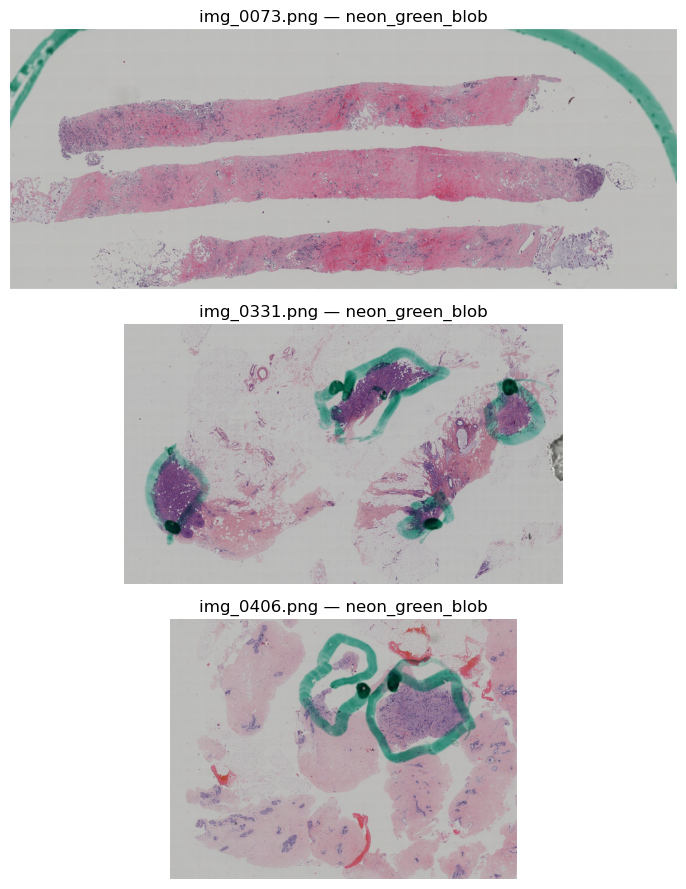

Trovati tipi di bug: ['neon_green_blob']


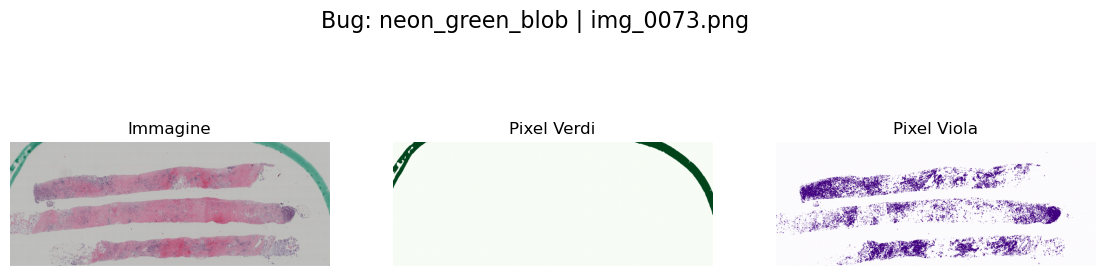

In [ ]:
# Run color-based quality check to detect anomalies and corrupted images
# This function identifies images with unusual color distributions (potential bugs)
df_full = run_color_qc(df, show_plots=True, n_plot=10)

In [ ]:
# Verify the enriched dataframe with QC flags
df_full.head()

,path,filename,image,ok,reason,neon_green,shrek_chroma,frac_tissue
0,an2dl2526c2v2/test_data/img_0000.png,img_0000.png,"[[[205, 205, 203], [195, 195, 193], [197, 197,...",True,,0.0,0.0,0.144013
1,an2dl2526c2v2/test_data/img_0001.png,img_0001.png,"[[[188, 188, 186], [188, 188, 186], [187, 187,...",True,,0.0,0.0,0.088450
2,an2dl2526c2v2/test_data/img_0002.png,img_0002.png,"[[[186, 185, 183], [185, 184, 182], [185, 184,...",True,,0.0,0.0,0.603558
3,an2dl2526c2v2/test_data/img_0003.png,img_0003.png,"[[[219, 219, 217], [191, 191, 189], [196, 196,...",True,,0.0,0.0,0.131817
4,an2dl2526c2v2/test_data/img_0004.png,img_0004.png,"[[[198, 198, 198], [187, 187, 187], [188, 188,...",True,,0.0,0.0,0.096787


## 3️⃣ Data Cleaning & Removal of Corrupted Images

Remove buggy images and their associated mask files. This step ensures data integrity for downstream tasks.

In [ ]:
import os
import pandas as pd

def clean_train_and_remove_masks(df_full):
    """
    Comprehensive data cleaning pipeline:
    - Split train/test from file paths
    - Identify buggy images in training set
    - Remove image and associated mask pair
    - Recreate clean training dataframe
    - Print detailed statistics
    """

    # ---- 1) Extract split (train/test) from file path ----
    def get_split_from_path(p):
        p = p.lower()
        if "train" in p:
            return "train"
        if "test" in p:
            return "test"
        return "unknown"

    df_full["split"] = df_full["path"].apply(get_split_from_path)

    df_train = df_full[df_full["split"] == "train"].reset_index(drop=True)
    df_test  = df_full[df_full["split"] == "test"].reset_index(drop=True)

    # ---- 2) Identify buggy images in training set ----
    df_bad_train = df_train[df_train["ok"] == False]
    print("Buggy images in train:", len(df_bad_train))

    # ---- 3) Helper function: convert image path to mask path ----
    def img_path_to_mask_path(img_path):
        folder = os.path.dirname(img_path)
        base   = os.path.basename(img_path)
        mask_name = base.replace("img_", "mask_")
        return os.path.join(folder, mask_name)

    # ---- 4) Remove files from disk ----
    removed_imgs = 0
    removed_masks = 0

    for path in df_bad_train["path"]:
        if os.path.exists(path):
            os.remove(path)
            removed_imgs += 1

        mask_path = img_path_to_mask_path(path)
        if os.path.exists(mask_path):
            os.remove(mask_path)
            removed_masks += 1

    print("Images removed:", removed_imgs)
    print("Masks removed:", removed_masks)

    # ---- 5) Recreate clean training dataframe ----
    df_train_clean = df_train[df_train["ok"]].reset_index(drop=True)

    # ---- 6) FINAL STATISTICS ----
    print("\n===== STATISTICS =====")
    print("Original train images:", len(df_train))
    print("Buggy train images:", len(df_train) - len(df_train_clean))
    print("Clean train images:", len(df_train_clean))

    perc_persa = (len(df_train) - len(df_train_clean)) / len(df_train)
    print(f"Percentage lost: {perc_persa*100:.2f}%")

    print("Test images:", len(df_test))
    print("========================\n")

    return df_train_clean, df_test

# Execute cleaning pipeline
df_train_clean, df_test = clean_train_and_remove_masks(df_full)

Immagini buggate nel train: 0
Immagini rimosse: 0
Maschere rimosse: 0

===== STATISTICHE =====
Train originali: 1162
Train buggate: 0
Train pulite: 1162
Percentuale persa: 0.00%
Test: 954



## 4️⃣ Mask Consistency Analysis

Validate alignment and coverage between tissue regions and lesion masks using IoU metrics.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from shrek_and_bug_detector import tissue_mask_hsv  # tissue detection utility


def img_path_to_mask_path(img_path):
    """
    Convert image path to corresponding mask path.
    Example: img_0000.png -> mask_0000.png (same folder)
    """
    folder = os.path.dirname(img_path)
    base   = os.path.basename(img_path)     # img_0000.png
    mask_name = base.replace("img_", "mask_")
    return os.path.join(folder, mask_name)


def compute_mask_tissue_overlap(df):
    """
    Compute mask-tissue alignment metrics for each image.
    
    Input:
      - df: DataFrame with 'path' (image path) and 'image' (RGB numpy array)
    
    Output:
      - DataFrame with overlap metrics:
        * frac_mask_on_tissue: % of mask pixels that fall on tissue
        * frac_tissue_covered: % of tissue region covered by mask
        * iou_mask_tissue: Intersection over Union (mask vs tissue)
    """
    rows = []

    for _, row in df.iterrows():
        img_path = row["path"]
        img_rgb  = row["image"]

        # Construct mask path
        mask_path = img_path_to_mask_path(img_path)
        if not os.path.exists(mask_path):
            rows.append({
                "path": img_path,
                "frac_mask_on_tissue": np.nan,
                "frac_tissue_covered": np.nan,
                "iou_mask_tissue": np.nan,
            })
            continue

        # Read mask (grayscale) and binarize
        mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask_gray is None:
            rows.append({
                "path": img_path,
                "frac_mask_on_tissue": np.nan,
                "frac_tissue_covered": np.nan,
                "iou_mask_tissue": np.nan,
            })
            continue

        mask_bin = mask_gray > 0          # Binary mask: True where lesion exists

        # Extract tissue region (removes gray background)
        H, S, V, tissue = tissue_mask_hsv(img_rgb)

        # Compute overlap metrics
        inter      = (mask_bin & tissue).sum()      # Intersection area
        union      = (mask_bin | tissue).sum()      # Union area
        mask_sum   = mask_bin.sum()                 # Total mask pixels
        tissue_sum = tissue.sum()                   # Total tissue pixels

        if mask_sum == 0 or tissue_sum == 0:
            frac_mask_on_tissue = np.nan
            frac_tissue_covered = np.nan
            iou = np.nan
        else:
            frac_mask_on_tissue = inter / mask_sum      # % mask on tissue
            frac_tissue_covered = inter / tissue_sum    # % tissue covered
            iou = inter / union if union > 0 else np.nan

        rows.append({
            "path": img_path,
            "frac_mask_on_tissue": float(frac_mask_on_tissue),
            "frac_tissue_covered": float(frac_tissue_covered),
            "iou_mask_tissue": float(iou),
        })

    return pd.DataFrame(rows)

# Compute overlap metrics for clean training set
df_overlap = compute_mask_tissue_overlap(df_train_clean)
df_overlap.head()

,path,frac_mask_on_tissue,frac_tissue_covered,iou_mask_tissue
0,an2dl2526c2v2/train_data/img_0000.png,0.971542,0.036766,0.036726
1,an2dl2526c2v2/train_data/img_0002.png,0.995693,0.043425,0.043416
2,an2dl2526c2v2/train_data/img_0003.png,0.754833,0.113054,0.109049
3,an2dl2526c2v2/train_data/img_0004.png,0.942380,0.040576,0.040475
4,an2dl2526c2v2/train_data/img_0006.png,0.974644,0.075526,0.075378


Plotto i 3 casi con IoU mask–tessuto più basso


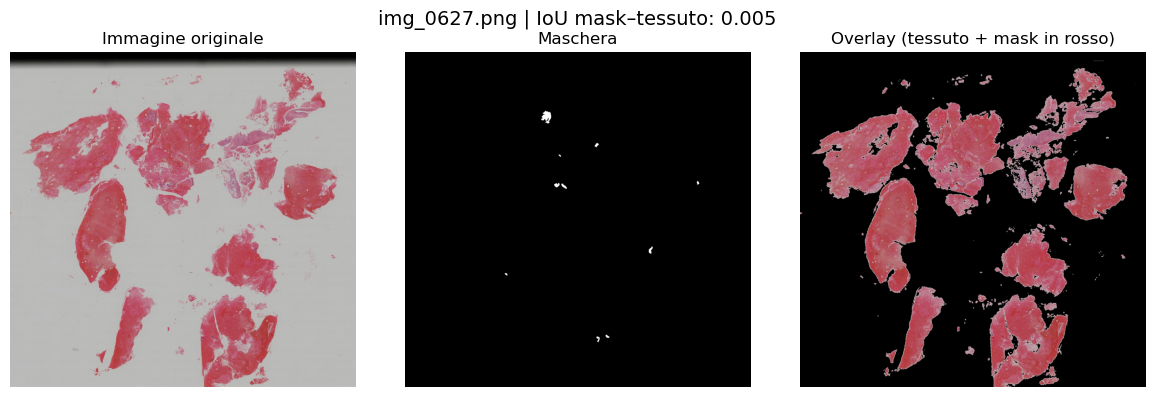

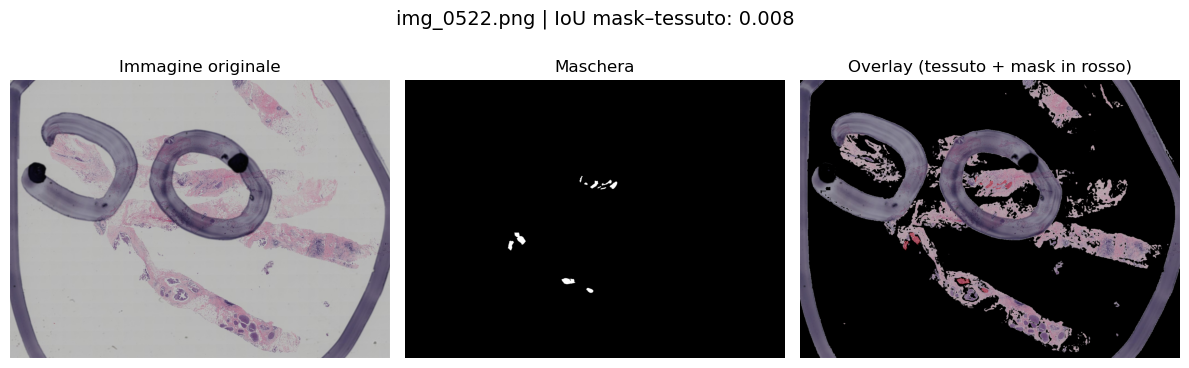

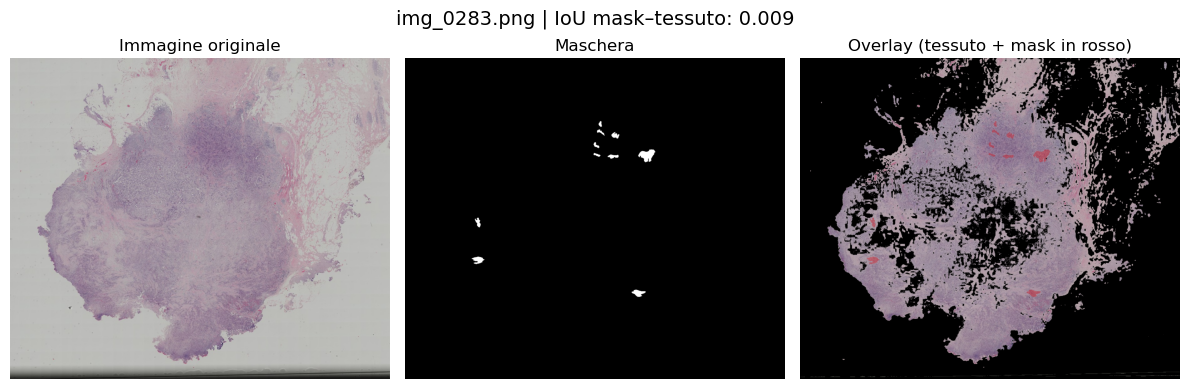

In [ ]:
def plot_low_overlap_examples(df_train_clean, df_overlap, k=10):
    """
    Visualize images with LOWEST mask-tissue IoU (poorest alignment).
    
    Displays for each example:
    - Original image
    - Binary mask
    - Overlay (mask in red on tissue background)
    
    df_train_clean: DataFrame with 'path' and 'image' (RGB)
    df_overlap: Output from compute_mask_tissue_overlap
    k: Number of worst cases to plot
    """
    # Merge image data with overlap metrics
    df_merged = df_train_clean.merge(df_overlap, on="path")

    # Filter NaN values and sort by IoU (ascending = worst first)
    df_merged = df_merged.dropna(subset=["iou_mask_tissue"])
    df_merged = df_merged.sort_values("iou_mask_tissue", ascending=True).reset_index(drop=True)

    k = min(k, len(df_merged))
    print(f"Plotting {k} cases with LOWEST mask-tissue IoU")

    for i in range(k):
        row = df_merged.iloc[i]
        img_path = row["path"]
        img_rgb  = row["image"]

        mask_path = img_path_to_mask_path(img_path)
        mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask_gray is None:
            continue
        mask_bin  = mask_gray > 0

        # Extract tissue to remove gray background
        H, S, V, tissue = tissue_mask_hsv(img_rgb)

        # Create overlay: background set to black, mask highlighted in red
        base = img_rgb.copy().astype(np.float32)
        base[~tissue] = 0  # Remove gray background

        colored_mask = np.zeros_like(base)
        colored_mask[..., 0] = 255  # Red channel

        overlay = base.copy()
        overlay[mask_bin] = 0.7 * overlay[mask_bin] + 0.3 * colored_mask[mask_bin]
        overlay = np.clip(overlay, 0, 255).astype(np.uint8)

        plt.figure(figsize=(12, 4))
        plt.suptitle(
            f"{os.path.basename(img_path)} | IoU mask-tissue: {row['iou_mask_tissue']:.3f}",
            fontsize=14
        )

        plt.subplot(1, 3, 1)
        plt.imshow(img_rgb)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_gray, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title("Overlay (tissue + red mask)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


# Visualize worst cases
plot_low_overlap_examples(df_train_clean, df_overlap, k=3)

Plotto i 3 casi con IoU mask–tessuto più ALTO


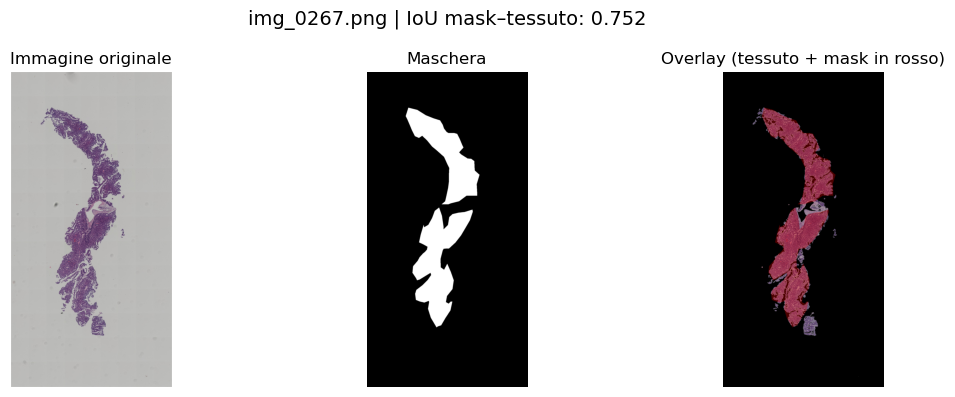

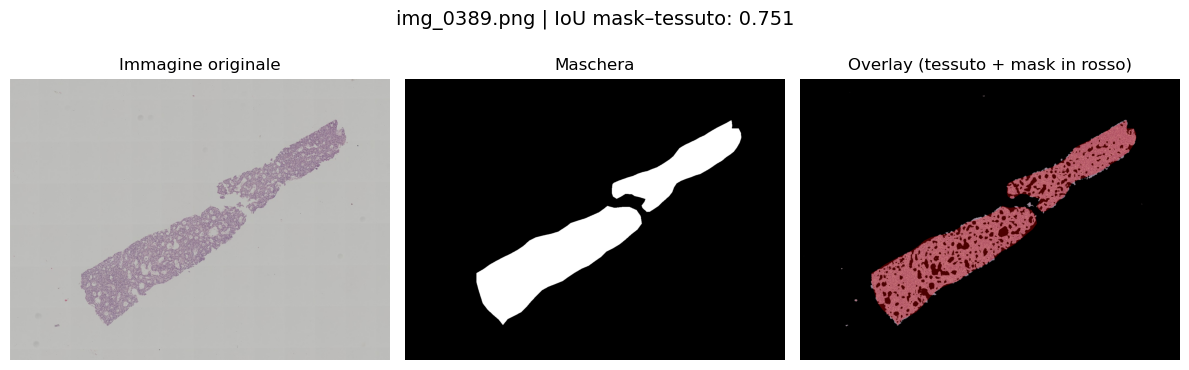

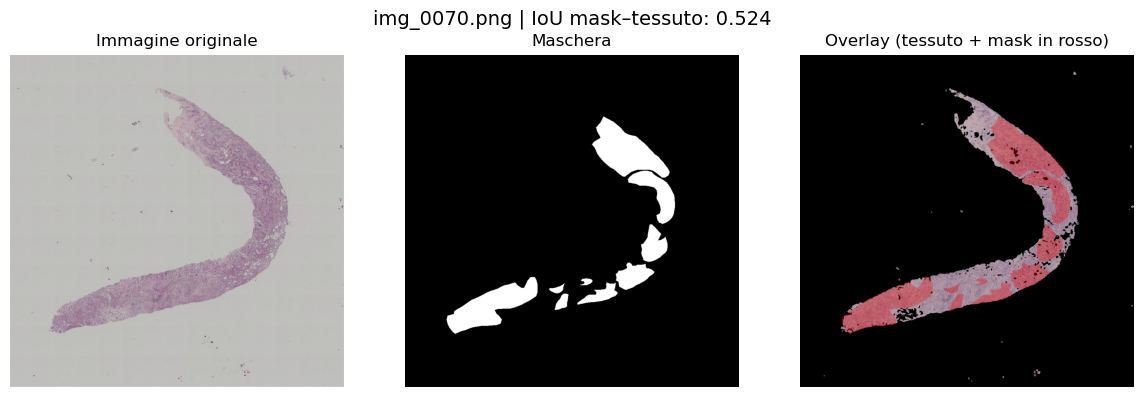

In [ ]:
def plot_best_overlap_examples(df_train_clean, df_overlap, k=10):
    """
    Visualize images with HIGHEST mask-tissue IoU (best alignment).
    
    Displays for each example:
    - Original image
    - Binary mask
    - Overlay (mask in red on tissue background)
    
    df_train_clean: DataFrame with 'path' and 'image' (RGB)
    df_overlap: Output from compute_mask_tissue_overlap
    k: Number of best cases to plot
    """
    # Merge image data with overlap metrics
    df_merged = df_train_clean.merge(df_overlap, on="path")

    # Filter NaN values and sort by IoU (descending = best first)
    df_merged = df_merged.dropna(subset=["iou_mask_tissue"])
    df_merged = df_merged.sort_values("iou_mask_tissue", ascending=False).reset_index(drop=True)

    k = min(k, len(df_merged))
    print(f"Plotting {k} cases with HIGHEST mask-tissue IoU")

    for i in range(k):
        row = df_merged.iloc[i]
        img_path = row["path"]
        img_rgb  = row["image"]

        mask_path = img_path_to_mask_path(img_path)
        mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask_gray is None:
            continue
        mask_bin  = mask_gray > 0

        # Extract tissue to remove gray background
        H, S, V, tissue = tissue_mask_hsv(img_rgb)

        # Create overlay: background set to black, mask highlighted in red
        base = img_rgb.copy().astype(np.float32)
        base[~tissue] = 0  # Remove gray background

        colored_mask = np.zeros_like(base)
        colored_mask[..., 0] = 255  # Red channel

        overlay = base.copy()
        overlay[mask_bin] = 0.7 * overlay[mask_bin] + 0.3 * colored_mask[mask_bin]
        overlay = np.clip(overlay, 0, 255).astype(np.uint8)

        plt.figure(figsize=(12, 4))
        plt.suptitle(
            f"{os.path.basename(img_path)} | IoU mask-tissue: {row['iou_mask_tissue']:.3f}",
            fontsize=14
        )

        plt.subplot(1, 3, 1)
        plt.imshow(img_rgb)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_gray, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title("Overlay (tissue + red mask)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Visualize best cases
plot_best_overlap_examples(df_train_clean, df_overlap, k=3)

In [ ]:
# Display summary statistics of mask-tissue overlap metrics
df_overlap[["frac_mask_on_tissue", "frac_tissue_covered", "iou_mask_tissue"]].describe()

,frac_mask_on_tissue,frac_tissue_covered,iou_mask_tissue
count,581.000000,581.000000,581.000000
mean,0.931577,0.141364,0.136107
std,0.119474,0.119546,0.108573
min,0.026014,0.004989,0.004989
25%,0.923404,0.061844,0.061360
50%,0.978134,0.103479,0.101636
75%,0.993312,0.178392,0.173646
max,1.000000,0.974261,0.752355


In [ ]:
def count_masks_below_threshold(df_overlap, threshold=0.75):
    """
    Identify and count masks with low tissue coverage (below threshold).
    
    Parameters:
      threshold: Minimum fraction of mask pixels that should be on tissue (0-1)
    
    Returns:
      DataFrame of problematic cases
    """
    df_bad = df_overlap[df_overlap["frac_mask_on_tissue"] < threshold]
    n_bad = len(df_bad)

    print(f"Images with mask below threshold {threshold}: {n_bad}")

    return df_bad

# Find poorly aligned masks
df_bad = count_masks_below_threshold(df_overlap, threshold=0.70)

Immagini con mask sotto soglia 0.7: 30


## 5️⃣ Image Size & Format Analysis

Analyze image dimensions, aspect ratios, and standardization requirements.

In [ ]:
def compute_image_sizes(df, column="image"):
    """
    Extract width and height for images in specified column.
    
    Parameters:
      df: DataFrame containing the image column
      column: Column name with numpy arrays (shape: H x W or H x W x C)
    
    Returns:
      DataFrame with 'width' and 'height' columns
    """
    widths = []
    heights = []

    for img in df[column]:
        if img is None:
            continue
        h, w = img.shape[:2]
        widths.append(w)
        heights.append(h)

    sizes_df = pd.DataFrame({
        "width": widths,
        "height": heights
    })

    return sizes_df

# Compute image dimensions for clean training set
df_sizes = compute_image_sizes(df_train_clean, column="image")

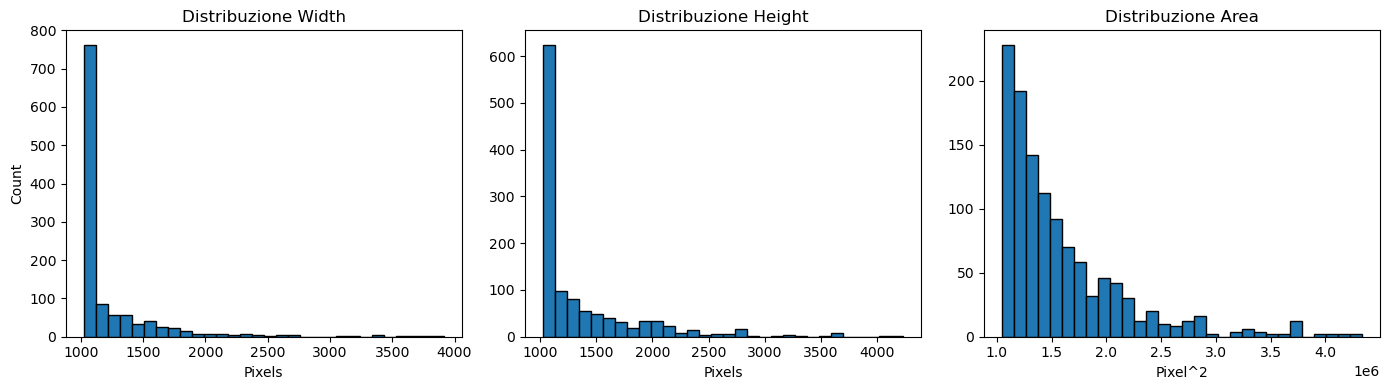

In [ ]:
import matplotlib.pyplot as plt

def plot_image_size_histograms(df_sizes):
    """
    Visualize distributions of image width, height, and area.
    Helps identify standardization needs for model input.
    """
    plt.figure(figsize=(14, 4))

    # Width distribution
    plt.subplot(1, 3, 1)
    plt.hist(df_sizes["width"], bins=30, edgecolor="black")
    plt.title("Width Distribution")
    plt.xlabel("Pixels")
    plt.ylabel("Count")

    # Height distribution
    plt.subplot(1, 3, 2)
    plt.hist(df_sizes["height"], bins=30, edgecolor="black")
    plt.title("Height Distribution")
    plt.xlabel("Pixels")

    # Area distribution
    plt.subplot(1, 3, 3)
    areas = df_sizes["width"] * df_sizes["height"]
    plt.hist(areas, bins=30, edgecolor="black")
    plt.title("Area Distribution")
    plt.xlabel("Pixel²")

    plt.tight_layout()
    plt.show()

# Visualize size distributions
plot_image_size_histograms(df_sizes)

In [ ]:
# Display summary statistics for image dimensions
df_sizes.describe()

,width,height
count,1162.000000,1162.000000
mean,1218.860585,1347.304647
std,405.255929,517.977181
min,1024.000000,1024.000000
25%,1024.000000,1024.000000
50%,1024.000000,1097.000000
75%,1259.000000,1481.000000
max,3914.000000,4233.000000


In [ ]:
# Count unique image formats (width, height combinations)
print("Unique formats:", df_sizes.value_counts().shape[0])
print(df_sizes.value_counts().head())

Formati unici: 475
width  height
1024   1392      10
       1568       8
       1057       8
1134   1024       8
1024   1026       8
Name: count, dtype: int64


In [ ]:
# Calculate and analyze aspect ratios (width/height)
df_sizes["aspect_ratio"] = df_sizes["width"] / df_sizes["height"]
df_sizes["aspect_ratio"].describe()

count    1162.000000
mean        1.024153
std         0.511679
min         0.241909
25%         0.691425
50%         0.933455
75%         1.229492
max         3.822266
Name: aspect_ratio, dtype: float64

In [ ]:
import os
import cv2
import pandas as pd

def check_image_mask_size(df):
    """
    Validate that each image and its corresponding mask have matching dimensions.
    
    Input:
      - df: DataFrame with 'path' and 'image'
    
    Output:
      - df_results: All image-mask pairs with size info
      - df_bad: Pairs with mismatched dimensions
    """
    paths = []
    img_w = []
    img_h = []
    mask_w = []
    mask_h = []
    ok = []

    # Process only image files (not masks)
    df_imgs = df[df["path"].str.contains("img_", na=False)].reset_index(drop=True)

    for _, row in df_imgs.iterrows():
        img_path = row["path"]
        img_rgb  = row["image"]

        # Extract image dimensions
        h, w = img_rgb.shape[:2]

        # Construct mask path
        mask_path = img_path.replace("img_", "mask_")

        mw = mh = None
        if os.path.exists(mask_path):
            m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if m is not None:
                mh, mw = m.shape[:2]

        paths.append(img_path)
        img_w.append(w)
        img_h.append(h)
        mask_w.append(mw)
        mask_h.append(mh)

        # Check if dimensions match
        ok.append((mw is not None) and (mh is not None) and (w == mw) and (h == mh))

    df_results = pd.DataFrame({
        "path": paths,
        "img_w": img_w,
        "img_h": img_h,
        "mask_w": mask_w,
        "mask_h": mask_h,
        "same_size": ok
    })

    df_bad = df_results[df_results["same_size"] == False]

    print(f"Total image-mask pairs checked: {len(df_results)}")
    print(f"Inconsistent pairs: {len(df_bad)}")

    return df_results, df_bad

# Validate image-mask alignment
df_results, df_bad = check_image_mask_size(df_train_clean)
df_bad.head()

Totale coppie img–mask controllate: 581
Coppie inconsistenti: 0


,path,img_w,img_h,mask_w,mask_h,same_size


In [ ]:
import cv2
import numpy as np
from shrek_and_bug_detector import tissue_mask_hsv  # tissue detection utility


# ====================================
# PREPROCESSING PIPELINE COMPONENTS
# ====================================

# 1) BACKGROUND COLOR ESTIMATION
def estimate_background_color(img_rgb):
    """
    Estimate the background color by finding the most frequent grayscale value.
    Returns (R, G, B) tuple with equal channels.
    Useful for consistent padding color.
    """
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    hist = np.bincount(gray.ravel(), minlength=256)
    bg = int(hist.argmax())
    return (bg, bg, bg)


# 2) TISSUE CROPPING
def crop_to_tissue(img_rgb, margin=10):
    """
    Crop image to the bounding box of tissue region with margin.
    Removes large gray areas of background.
    
    Parameters:
      img_rgb: Input RGB image (numpy array)
      margin: Pixel margin around tissue boundary
    
    Returns:
      Cropped image
    """
    H, S, V, tissue = tissue_mask_hsv(img_rgb)

    if not tissue.any():
        return img_rgb

    ys, xs = np.where(tissue)
    y_min = max(ys.min() - margin, 0)
    y_max = min(ys.max() + margin, img_rgb.shape[0] - 1)
    x_min = max(xs.min() - margin, 0)
    x_max = min(xs.max() + margin, img_rgb.shape[1] - 1)

    return img_rgb[y_min:y_max+1, x_min:x_max+1]


# 3) RESIZE WITH PADDING
def resize_with_padding(img_rgb, target_size=256, pad_value=None):
    """
    Resize image while maintaining aspect ratio, then pad to square.
    
    Pipeline:
    1. Maintains aspect ratio
    2. Resizes so longest side = target_size
    3. Pads with background color to create target_size × target_size square
    
    Parameters:
      img_rgb: Input RGB image
      target_size: Target square dimension (pixels)
      pad_value: Padding color (None = auto-detect background)
    
    Returns:
      Square image of size target_size × target_size
    """
    h, w = img_rgb.shape[:2]
    scale = target_size / max(h, w)

    new_w = int(round(w * scale))
    new_h = int(round(h * scale))

    # Resize maintaining aspect ratio
    img_resized = cv2.resize(img_rgb, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Determine padding color
    if pad_value is None:
        pad_color = estimate_background_color(img_rgb)
    else:
        if isinstance(pad_value, (int, float)):
            pad_color = (pad_value, pad_value, pad_value)
        else:
            pad_color = tuple(pad_value)

    # Create square canvas with padding
    canvas = np.full((target_size, target_size, 3), pad_color, dtype=img_resized.dtype)

    # Center image on canvas
    y_off = (target_size - new_h) // 2
    x_off = (target_size - new_w) // 2

    canvas[y_off:y_off+new_h, x_off:x_off+new_w] = img_resized

    return canvas


# 4) COMPLETE PREPROCESSING PIPELINE
def preprocess_image_for_clf(img_rgb, target_size=256, do_crop_tissue=True):
    """
    Complete preprocessing pipeline: crop tissue → resize with padding.
    
    Parameters:
      img_rgb: Input RGB image
      target_size: Target square size
      do_crop_tissue: Whether to crop to tissue region
    
    Returns:
      Preprocessed square image
    """
    if do_crop_tissue:
        img_rgb = crop_to_tissue(img_rgb)

    img_sq = resize_with_padding(img_rgb, target_size=target_size, pad_value=None)
    return img_sq


# 5) APPLY PREPROCESSING TO DATASET
TARGET_SIZE = 1000

# Preprocess all training images (store in new column)
df_train_clean["image_proc"] = df_train_clean["image"].apply(
    lambda im: preprocess_image_for_clf(im, target_size=TARGET_SIZE, do_crop_tissue=True)
)

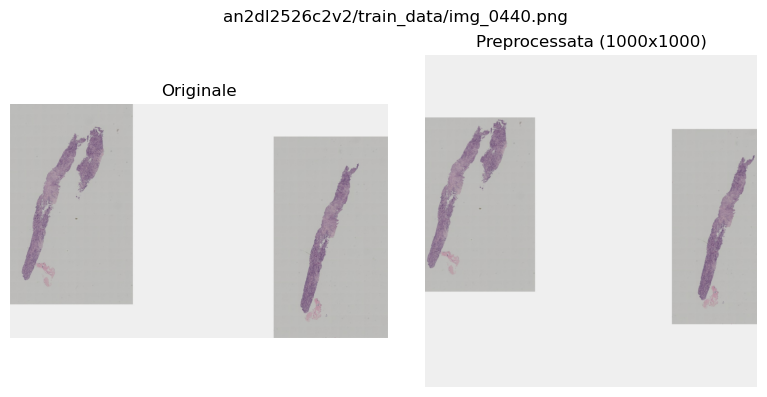

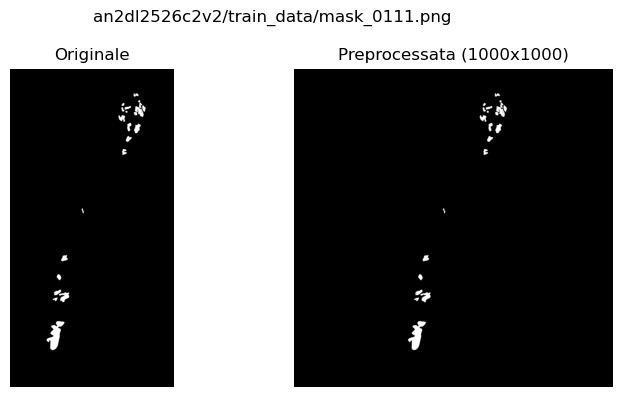

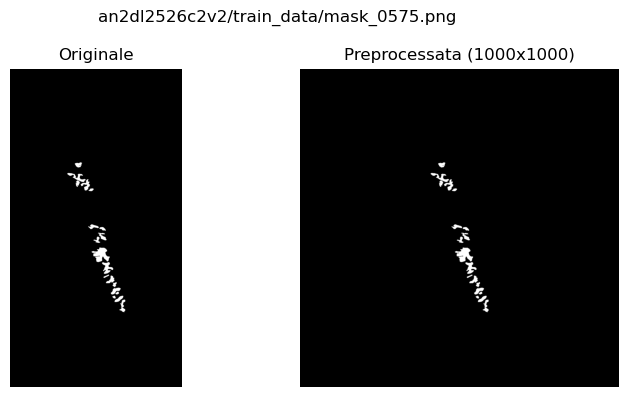

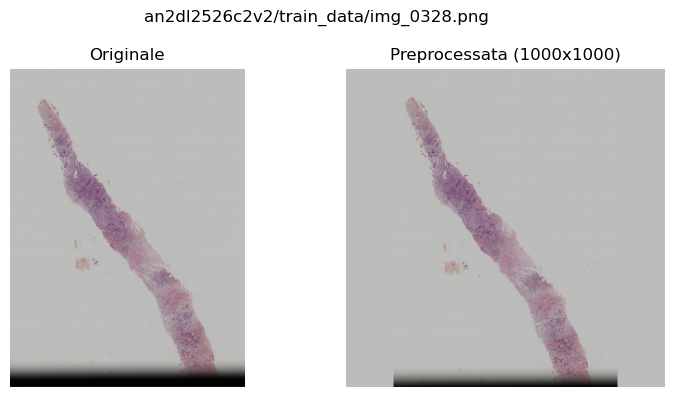

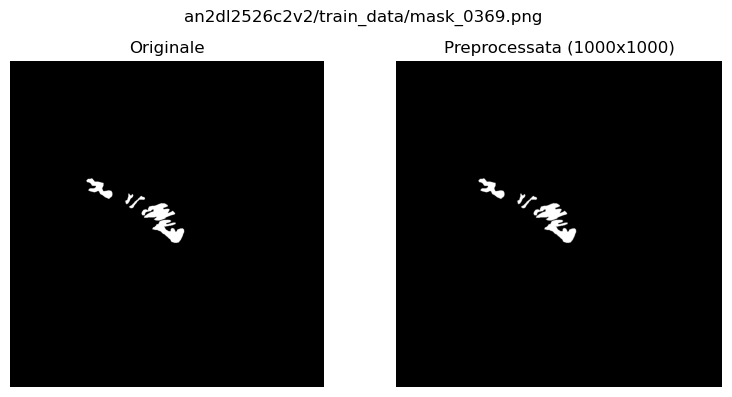

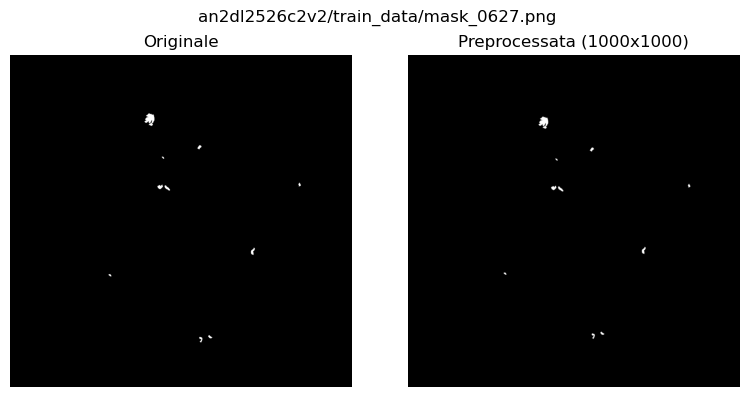

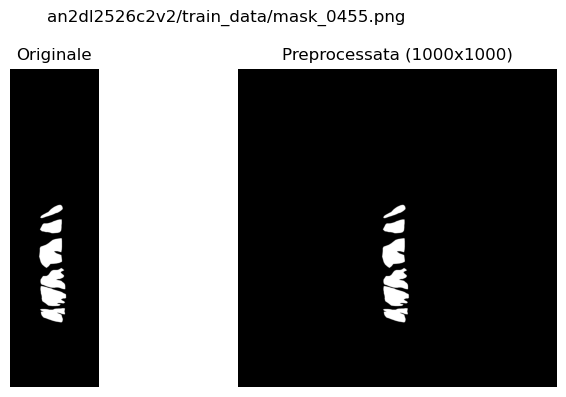

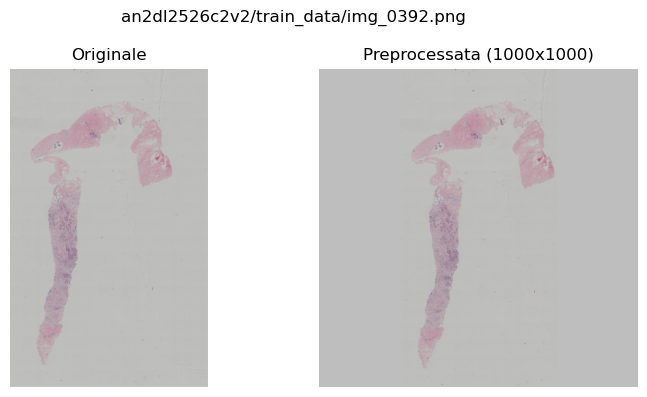

In [ ]:
import matplotlib.pyplot as plt
import random

def show_preprocessing_examples(df, n=6):
    """
    Visualize preprocessing results: original vs preprocessed images.
    
    Randomly selects n examples and displays side-by-side comparison.
    
    Parameters:
      df: DataFrame with 'image' and 'image_proc' columns
      n: Number of examples to display
    """
    # Filter rows with preprocessed images
    df_ok = df[df["image_proc"].notna()].reset_index(drop=True)

    n = min(n, len(df_ok))
    idxs = random.sample(range(len(df_ok)), n)

    for idx in idxs:
        row = df_ok.iloc[idx]
        img_orig = row["image"]
        img_proc = row["image_proc"]
        path     = row.get("path", "")

        plt.figure(figsize=(8, 4))
        title = path if isinstance(path, str) else ""
        plt.suptitle(title, fontsize=12)

        plt.subplot(1, 2, 1)
        plt.imshow(img_orig)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(img_proc)
        plt.title(f"Preprocessed ({img_proc.shape[1]}×{img_proc.shape[0]})")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

# Display preprocessing examples
show_preprocessing_examples(df_train_clean, n=8)

In [ ]:
# Apply same preprocessing to test set
df_test["image_proc"] = df_test["image"].apply(
    lambda im: preprocess_image_for_clf(im, target_size=TARGET_SIZE, do_crop_tissue=True)
)

# Verify test set preprocessing
print(f"Test set preprocessed: {len(df_test)} images")
print(f"Preprocessed shape: {df_test['image_proc'].iloc[0].shape}")

Test set preprocessato: 954 immagini
Shape preprocessata: (1000, 1000, 3)


In [ ]:
import pandas as pd
import os

# Load original labels from CSV
labels_path = "/Users/danieleuras/Documents/Challenge2/an2dl_challenge2/train_labels.csv"
df_labels = pd.read_csv(labels_path)

print(f"Original labels: {len(df_labels)}")

# Extract filenames from cleaned training images
train_clean_filenames = df_train_clean["path"].apply(
    lambda p: os.path.basename(p)
).tolist()

# Filter labels to keep only those corresponding to clean images
df_labels_clean = df_labels[df_labels["sample_index"].isin(train_clean_filenames)].reset_index(drop=True)

print(f"Clean labels: {len(df_labels_clean)}")
print(f"Labels removed: {len(df_labels) - len(df_labels_clean)}")

# Save cleaned labels for later use
output_path = "/Users/danieleuras/Documents/Challenge2/an2dl_challenge2/train_labels_clean.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df_labels_clean.to_csv(output_path, index=False)

print(f"\n✓ Saved to {output_path}")
df_labels_clean.head()

Label originali: 691
Label pulite: 581
Label rimosse: 110

✓ Salvato /Users/danieleuras/Documents/Challenge2/an2dl_challenge2/train_labels_clean.csv


,sample_index,label
0,img_0000.png,Triple negative
1,img_0002.png,Luminal B
2,img_0003.png,Luminal B
3,img_0004.png,Luminal B
4,img_0006.png,Luminal A


In [ ]:
import os
import shutil
from tqdm import tqdm
from PIL import Image
import os
from tqdm import tqdm

def save_and_resize_images_and_masks(
    df_train,
    df_test,
    base_dir="/Users/danieleuras/Documents/Challenge2/an2dl_challenge2",
    size=256,
):
    """
    Save and resize images and masks to standardized size.
    Uses PIL for better quality control over interpolation methods.
    
    Directory structure created:
      base_dir/
        train/
          images/
          masks/
        test/
          images/
          masks/
    
    Parameters:
      df_train, df_test: DataFrames with 'path' column
      base_dir: Base directory for output
      size: Target dimension for resizing (creates size × size images)
    """
    train_img_dir  = os.path.join(base_dir, "train", "images")
    train_mask_dir = os.path.join(base_dir, "train", "masks")
    test_img_dir   = os.path.join(base_dir, "test", "images")
    test_mask_dir  = os.path.join(base_dir, "test", "masks")

    # Create directories
    for d in [train_img_dir, train_mask_dir, test_img_dir, test_mask_dir]:
        os.makedirs(d, exist_ok=True)

    # --- TRAIN ---
    train_masks_copied = 0
    for _, row in tqdm(df_train.iterrows(), total=len(df_train), desc="Train"):
        img_path = row["path"]
        img_name = os.path.basename(img_path)
        dest_img = os.path.join(train_img_dir, img_name)

        # Process and save image with BILINEAR interpolation
        img = Image.open(img_path).convert("RGB")
        img = img.resize((size, size), Image.BILINEAR)
        img.save(dest_img)

        # Process and save mask with NEAREST interpolation (preserve mask values)
        mask_path = img_path_to_mask_path(img_path)
        if os.path.exists(mask_path):
            mask_name = os.path.basename(mask_path)
            dest_mask = os.path.join(train_mask_dir, mask_name)

            mask = Image.open(mask_path)
            mask = mask.resize((size, size), Image.NEAREST)
            mask.save(dest_mask)
            train_masks_copied += 1

    # --- TEST ---
    test_masks_copied = 0
    for _, row in tqdm(df_test.iterrows(), total=len(df_test), desc="Test"):
        img_path = row["path"]
        img_name = os.path.basename(img_path)
        dest_img = os.path.join(test_img_dir, img_name)

        # Process and save image
        img = Image.open(img_path).convert("RGB")
        img = img.resize((size, size), Image.BILINEAR)
        img.save(dest_img)

        # Process and save mask if exists
        mask_path = img_path_to_mask_path(img_path)
        if os.path.exists(mask_path):
            mask_name = os.path.basename(mask_path)
            dest_mask = os.path.join(test_mask_dir, mask_name)

            mask = Image.open(mask_path)
            mask = mask.resize((size, size), Image.NEAREST)
            mask.save(dest_mask)
            test_masks_copied += 1

    print(f"\n✓ Saved {len(df_train)} images + {train_masks_copied} masks to train in {train_img_dir}")
    print(f"✓ Saved {len(df_test)} images + {test_masks_copied} masks to test in {test_img_dir}")
    print(f"\nDataset structure created at: {os.path.abspath(base_dir)}")


# Execute: save and resize all images and masks
save_and_resize_images_and_masks(df_train_clean, df_test, size=1000)

Test: 100%|██████████| 954/954 [00:59<00:00, 16.01it/s]


✓ Salvate 1162 immagini + 1162 maschere train in /Users/danieleuras/Documents/Challenge2/an2dl_challenge2/train/images
✓ Salvate 954 immagini + 954 maschere test in /Users/danieleuras/Documents/Challenge2/an2dl_challenge2/test/images

Struttura creata in: /Users/danieleuras/Documents/Challenge2/an2dl_challenge2


## 6️⃣ Dataset Organization & DataLoader Preparation

Organize cleaned data into structured directories and prepare for model training.

### Original Files Organization

Copying original files without preprocessing

Practical example: create dataset and dataloader from disk structure `an2dl_challenge2/`

In [ ]:
import os
import shutil
from tqdm import tqdm

def save_images_and_masks_split(
    df_train,
    df_test,
    base_dir="/Users/danieleuras/Documents/Challenge2/an2dl_challenge2_original",
):
    """
    Copy images and masks WITHOUT preprocessing.
    Preserves original file formats and dimensions.
    
    Creates directory structure:
      base_dir/
        train/
          images/
          masks/
        test/
          images/
          masks/
    """
    train_img_dir  = os.path.join(base_dir, "train", "images")
    train_mask_dir = os.path.join(base_dir, "train", "masks")
    test_img_dir   = os.path.join(base_dir, "test", "images")
    test_mask_dir  = os.path.join(base_dir, "test", "masks")

    # Create directories
    for d in [train_img_dir, train_mask_dir, test_img_dir, test_mask_dir]:
        os.makedirs(d, exist_ok=True)

    # --- TRAIN ---
    print("Copying train images and masks...")
    train_masks_copied = 0
    df_train_imgs = df_train[df_train["path"].str.contains("img_", na=False)].reset_index(drop=True)
    
    for _, row in tqdm(df_train_imgs.iterrows(), total=len(df_train_imgs)):
        img_path = row["path"]
        img_name = os.path.basename(img_path)
        dest_img = os.path.join(train_img_dir, img_name)
        
        # Copy image file
        shutil.copy2(img_path, dest_img)
        
        # Copy corresponding mask if exists
        mask_path = img_path_to_mask_path(img_path)
        if os.path.exists(mask_path):
            mask_name = os.path.basename(mask_path)
            dest_mask = os.path.join(train_mask_dir, mask_name)
            shutil.copy2(mask_path, dest_mask)
            train_masks_copied += 1

    # --- TEST ---
    print("Copying test images and masks...")
    test_masks_copied = 0
    df_test_imgs = df_test[df_test["path"].str.contains("img_", na=False)].reset_index(drop=True)
    
    for _, row in tqdm(df_test_imgs.iterrows(), total=len(df_test_imgs)):
        img_path = row["path"]
        img_name = os.path.basename(img_path)
        dest_img = os.path.join(test_img_dir, img_name)
        
        # Copy image file
        shutil.copy2(img_path, dest_img)
        
        # Copy corresponding mask if exists
        mask_path = img_path_to_mask_path(img_path)
        if os.path.exists(mask_path):
            mask_name = os.path.basename(mask_path)
            dest_mask = os.path.join(test_mask_dir, mask_name)
            shutil.copy2(mask_path, dest_mask)
            test_masks_copied += 1

    print(f"\n✓ Saved {len(df_train_imgs)} images + {train_masks_copied} masks to train in {train_img_dir}")
    print(f"✓ Saved {len(df_test_imgs)} images + {test_masks_copied} masks to test in {test_img_dir}")
    print(f"\nDataset structure created at: {os.path.abspath(base_dir)}")


# Execute: copy original files with train/test split
save_images_and_masks_split(df_train_clean, df_test)

Copiando train images e masks...


100%|██████████| 581/581 [00:00<00:00, 694.97it/s]


Copiando test images e masks...


100%|██████████| 477/477 [00:00<00:00, 693.02it/s]


✓ Salvate 581 immagini + 581 maschere train in /Users/danieleuras/Documents/Challenge2/an2dl_challenge2_original/train/images
✓ Salvate 477 immagini + 477 maschere test in /Users/danieleuras/Documents/Challenge2/an2dl_challenge2_original/test/images

Struttura creata in: /Users/danieleuras/Documents/Challenge2/an2dl_challenge2_original


In [ ]:
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# =========================================
# DATASET CONSTRUCTION FOR MODEL TRAINING
# =========================================

BASE_DIR = "/Users/danieleuras/Documents/Challenge2/an2dl_challenge2"
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train", "images")
TEST_IMG_DIR = os.path.join(BASE_DIR, "test", "images")
LABELS_CSV = os.path.join(BASE_DIR, "train_labels_clean.csv")  # Created earlier

# Load clean labels (columns: sample_index, label)
df_labels = pd.read_csv(LABELS_CSV)

# Create training dataframe with absolute paths and labels
train_rows = []
for _, row in df_labels.iterrows():
    fname = row["sample_index"]  # e.g., img_0123.png
    label = row["label"]
    img_path = os.path.join(TRAIN_IMG_DIR, fname)
    
    if os.path.exists(img_path):
        train_rows.append({"path": img_path, "label": label})
    else:
        print(f"[WARN] File not found: {img_path}")

df_train_disk = pd.DataFrame(train_rows)
print(f"Training images found: {len(df_train_disk)}")

# Create test dataframe (no labels available)
test_paths = sorted(glob.glob(os.path.join(TEST_IMG_DIR, "*.png")))
df_test_disk = pd.DataFrame({"path": test_paths})
print(f"Test images found: {len(df_test_disk)}")

# Split training set into train/val (80/20 split, stratified by label)
df_tr, df_val = train_test_split(
    df_train_disk, 
    test_size=0.2, 
    random_state=42, 
    stratify=df_train_disk["label"]
)

print(f"\nTrain split: {len(df_tr)} images")
print(f"Validation split: {len(df_val)} images")

# =========================================
# DATALOADER CREATION (PLACEHOLDER)
# =========================================
# NOTE: Uncomment and configure based on your custom dataset implementation
# train_loader, val_loader, label_map = create_dataloaders(
#     df_tr,
#     df_valid=df_val,
#     label_map=None,
#     batch_size=16,
#     num_workers=0,
#     use_processed=False,  # Load from disk, not preprocessed column
#     resize_to=256,
# )
# 
# print("Label map:", label_map)
# 
# # Example batch iteration
# batch = next(iter(train_loader))
# print(batch["image"].shape, batch["label"].shape)

Train trovati: 581
Test trovati: 954
Label map: {'HER2(+)': 0, 'Luminal A': 1, 'Luminal B': 2, 'Triple negative': 3}


/opt/homebrew/Caskroom/miniconda/base/envs/capstone/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([16, 3, 256, 256]) torch.Size([16])
